# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ). 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.mm

# Model 1 Linear Estimator

In [44]:
import os
import zipfile 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
instance_type='ml.m4.xlarge'
import warnings
warnings.filterwarnings('ignore')

In [1]:
import zipfile
import pandas as pd

# Path to your local ZIP file
zip_path = 'combined_csv_v1.zip'

# Open the ZIP file and read the single CSV file inside
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get the name of the only CSV file
    csv_filename = zip_ref.namelist()[0]
    print("CSV file found:", csv_filename)
    
    # Load the CSV directly from the ZIP file
    with zip_ref.open(csv_filename) as csv_file:
        df1 = pd.read_csv(csv_file)

CSV file found: combined_csv_v1.csv


In [2]:
from sklearn.model_selection import train_test_split

# Define a function for 70-15-15 train-test-validation split
def split_data(df):
    # First split: 70% train, 30% (test + validation)
    train, test_and_validate = train_test_split(df, test_size=0.3, random_state=42, stratify=df['target'])
    # Second split: 15% test, 15% validation from the 30%
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, test, validate

# Apply split to both datasets
train, test, validate = split_data(df1)

In [4]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
import numpy as np
### Create train, validate, and test records
train_records = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

In [9]:
classifier_estimator.fit([train_records,val_records], logs=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-01-06-31-47-238



2024-11-01 06:31:48 Starting - Starting the training job....
2024-11-01 06:32:13 Starting - Preparing the instances for training.........
2024-11-01 06:33:05 Downloading - Downloading input data.......
2024-11-01 06:33:45 Downloading - Downloading the training image...............
2024-11-01 06:35:06 Training - Training image download completed. Training in progress...................................................
2024-11-01 06:39:22 Uploading - Uploading generated training model.
2024-11-01 06:39:35 Completed - Training job completed


In [10]:
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]
print("Available Buckets:", buckets)

Available Buckets: ['c135321a3429026l8211331t1w47111294729-flightbucket-anjn4aypwk0g', 'sagemaker-us-east-1-471112947298']


In [17]:
import io
bucket='c135321a3429026l8211331t1w47111294729-flightbucket-anjn4aypwk0g'
prefix='flight-linear'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [18]:
import os
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

In [82]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-01-09-13-46-847
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-01-09-13-47-574


.................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/01/2024 09:21:57 INFO 139802078017344] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/01/2024 09:22:01 WARNING 139802078017344] Loggers have already been setup.
[11/01/2024 09:22:01 INFO 139802078017344] loaded entry point class algorithm.serve.server_config:config_api
[11/01/2024 09:22:01 INFO 139802078017344] loading entry points
[11/01/2

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

In [37]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

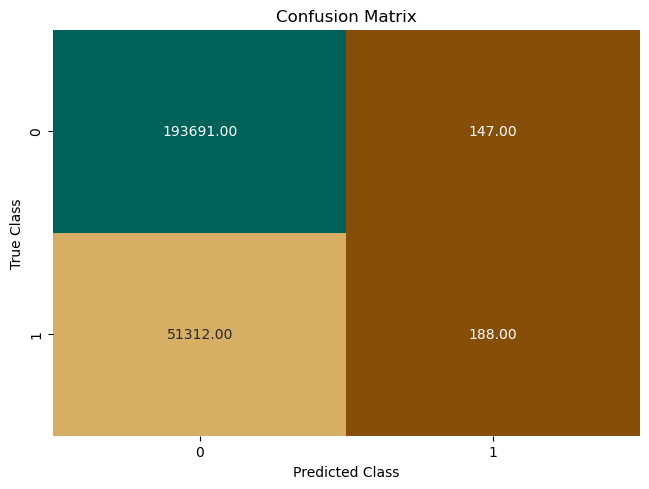

In [28]:
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR:  0.3650485436893204 %
Specificity or TNR:  99.92416347671768 %
Precision:  56.11940298507463 %
Negative Predictive Value:  79.05658298061657 %
False Positive Rate:  0.07583652328232854 %
False Negative Rate:  99.63495145631069 %
False Discovery Rate:  43.88059701492537 %
Accuracy:  79.0252631064083 %
Validation AUC 0.501446060102035
Figure(640x480)


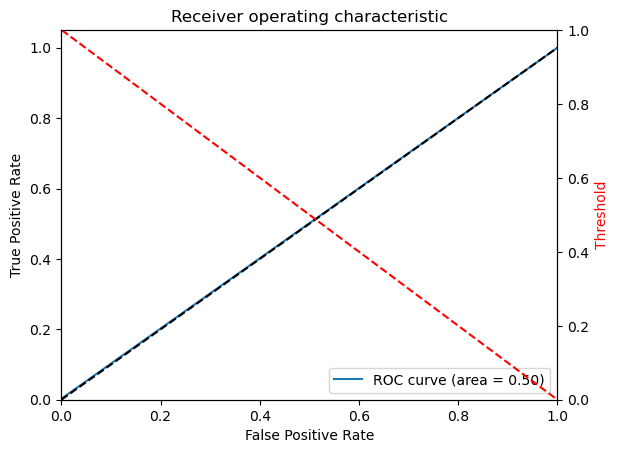

<Figure size 640x480 with 0 Axes>

In [38]:
plot_roc(test_labels, target_predicted)

# Model 2 Linear Estimator

In [40]:
import zipfile
import pandas as pd

# Path to your local ZIP file
zip_path = 'combined_csv_v2.zip'

# Open the ZIP file and read the single CSV file inside
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get the name of the only CSV file
    csv_filename = zip_ref.namelist()[0]
    print("CSV file found:", csv_filename)
    
    # Load the CSV directly from the ZIP file
    with zip_ref.open(csv_filename) as csv_file:
        df2 = pd.read_csv(csv_file)

CSV file found: combined_csv_v2.csv


In [41]:
train, test, validate = split_data(df2)

In [42]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')

In [43]:
import numpy as np
### Create train, validate, and test records
train_records = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

In [45]:
classifier_estimator.fit([train_records,val_records], logs=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-01-07-55-21-543



2024-11-01 07:55:22 Starting - Starting the training job.
2024-11-01 07:55:36 Starting - Preparing the instances for training......
2024-11-01 07:56:10 Downloading - Downloading input data........
2024-11-01 07:56:55 Downloading - Downloading the training image...........
2024-11-01 07:57:56 Training - Training image download completed. Training in progress...........................................
2024-11-01 08:01:32 Uploading - Uploading generated training model.
2024-11-01 08:01:45 Completed - Training job completed


In [47]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-01-08-01-50-075
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-01-08-01-50-669


.................................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/01/2024 08:10:03 INFO 140621846443840] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/01/2024 08:10:07 WARNING 140621846443840] Loggers have already been setup.
[11/01/2024 08:10:07 INFO 140621846443840] loaded entry point class algorithm.serve.server_config:config_api
[11/01/2024 08:10:07 INFO 140621846443840] loading entry points
[11/01/2

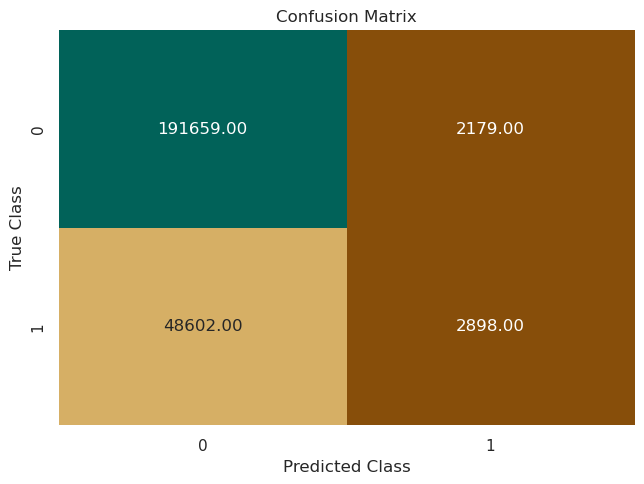

In [51]:
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR:  5.6271844660194175 %
Specificity or TNR:  98.87586541338644 %
Precision:  57.08095331888911 %
Negative Predictive Value:  79.77116552415914 %
False Positive Rate:  1.124134586613564 %
False Negative Rate:  94.37281553398059 %
False Discovery Rate:  42.91904668111089 %
Accuracy:  79.30161654533745 %
Validation AUC 0.5225152493970292
Figure(640x480)


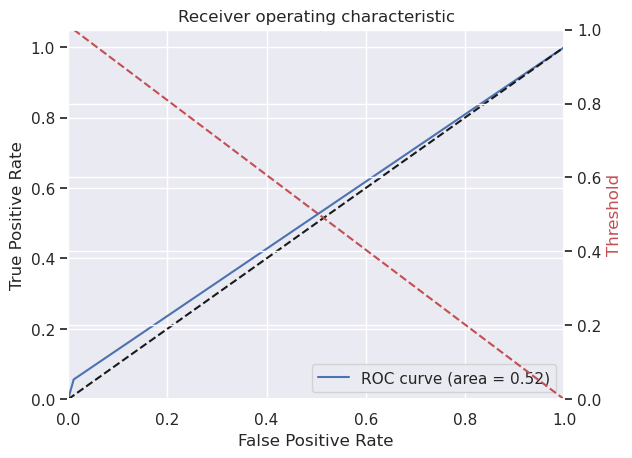

<Figure size 640x480 with 0 Axes>

In [52]:
plot_roc(test_labels, target_predicted)

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

# Model 1 Ensemble Method

In [53]:
train, test, validate = split_data(df1)

In [54]:
bucket='c135321a3429026l8211331t1w47111294729-flightbucket-anjn4aypwk0g'
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [55]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [56]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [57]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-01-08-32-30-091


2024-11-01 08:32:32 Starting - Starting the training job...
2024-11-01 08:32:47 Starting - Preparing the instances for training...
2024-11-01 08:33:11 Downloading - Downloading input data...
2024-11-01 08:33:46 Downloading - Downloading the training image.....[2024-11-01 08:34:46.528 ip-10-0-146-97.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is '

In [58]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [59]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-01-08-38-22-349
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-01-08-38-22-915


.........................................[2024-11-01:08:45:14:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:08:45:14:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:08:45:14:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-01 08:45:14 +0000] [19] [INFO] Sta

In [60]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

In [61]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.153311
1  0.221695
2  0.121166
3  0.158379
4  0.086796
   target
0       0
1       0
2       0
3       0
4       0


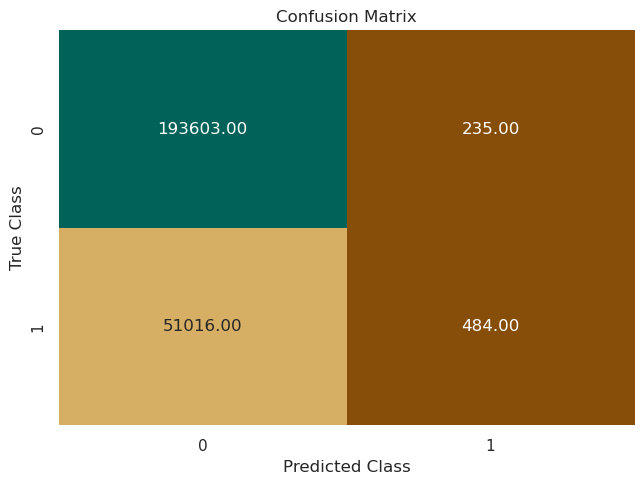

In [62]:
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR:  0.9398058252427184 %
Specificity or TNR:  99.87876474169151 %
Precision:  67.31571627260084 %
Negative Predictive Value:  79.14471075427501 %
False Positive Rate:  0.12123525830848439 %
False Negative Rate:  99.06019417475727 %
False Discovery Rate:  32.68428372739917 %
Accuracy:  79.11004410242197 %
Validation AUC 0.5040928528346711
Figure(640x480)


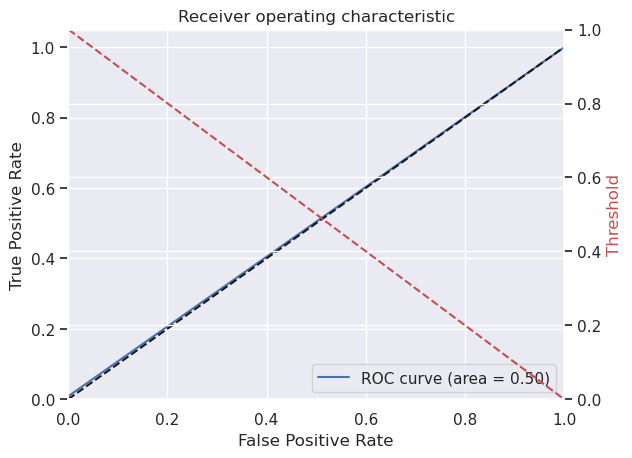

<Figure size 640x480 with 0 Axes>

In [63]:
plot_roc(test_labels, target_predicted)

# Model 2 Ensemble Method

In [64]:
train, test, validate = split_data(df2)

In [65]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [66]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [67]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [68]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-01-08-46-25-350


2024-11-01 08:46:26 Starting - Starting the training job...
2024-11-01 08:46:40 Starting - Preparing the instances for training...
2024-11-01 08:47:16 Downloading - Downloading input data...
2024-11-01 08:47:56 Downloading - Downloading the training image......
2024-11-01 08:48:36 Training - Training image download completed. Training in progress.[2024-11-01 08:48:51.853 ip-10-0-191-0.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:D

In [69]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [70]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-01-08-53-19-051
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-01-08-53-19-711


......................................[2024-11-01:08:59:41:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:08:59:41:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-01:08:59:41:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-01 08:59:41 +0000] [19] [INFO] Starti

In [71]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

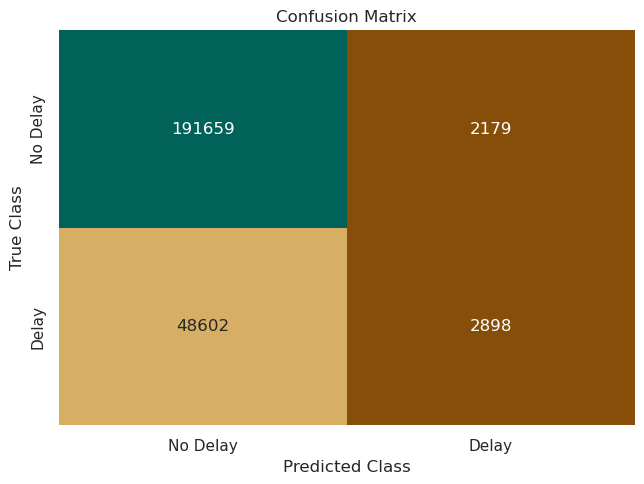

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted, threshold=0.5):
    # Convert probability predictions to binary predictions
    binary_predictions = (target_predicted >= threshold).astype(int)
    
    # Generate the confusion matrix
    matrix = confusion_matrix(test_labels, binary_predictions)
    df_confusion = pd.DataFrame(matrix, index=["No Delay", "Delay"], columns=["No Delay", "Delay"])
    
    # Plotting the confusion matrix
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='d', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

# Example usage with threshold 0.5
plot_confusion_matrix(test_labels, target_predicted, threshold=1.0)



Sensitivity or TPR: 5.6271844660194175 %
Specificity or TNR: 98.87586541338644 %
Precision: 57.08095331888911 %
Negative Predictive Value: 79.77116552415914 %
False Positive Rate: 1.124134586613564 %
False Negative Rate: 94.37281553398059 %
False Discovery Rate: 42.91904668111089 %
Accuracy: 79.30161654533745 %
Validation AUC: 0.5225152493970292


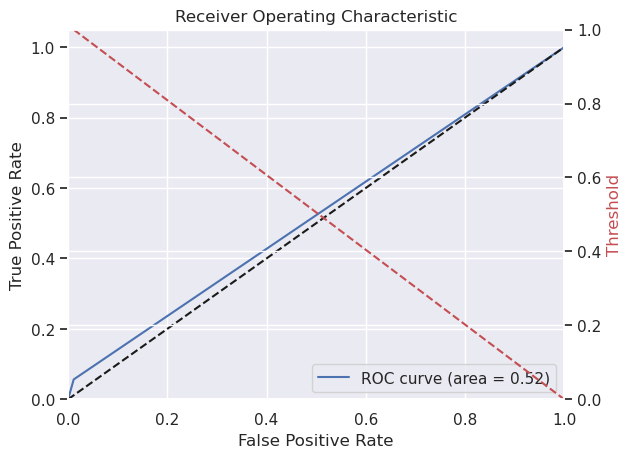

In [84]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_roc(test_labels, target_predicted, threshold=0.5):
    # Convert continuous predictions to binary predictions based on a threshold
    binary_predictions = (target_predicted >= threshold).astype(int)
    
    # Calculate confusion matrix components
    TN, FP, FN, TP = confusion_matrix(test_labels, binary_predictions).ravel()
    
    # Calculate and print metrics
    Sensitivity = float(TP) / (TP + FN) * 100
    Specificity = float(TN) / (TN + FP) * 100
    Precision = float(TP) / (TP + FP) * 100
    NPV = float(TN) / (TN + FN) * 100
    FPR = float(FP) / (FP + TN) * 100
    FNR = float(FN) / (TP + FN) * 100
    FDR = float(FP) / (TP + FP) * 100
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100

    print("Sensitivity or TPR:", Sensitivity, "%") 
    print("Specificity or TNR:", Specificity, "%") 
    print("Precision:", Precision, "%") 
    print("Negative Predictive Value:", NPV, "%") 
    print("False Positive Rate:", FPR, "%")
    print("False Negative Rate:", FNR, "%") 
    print("False Discovery Rate:", FDR, "%" )
    print("Accuracy:", ACC, "%") 

    # Calculate and print AUC
    auc_score = metrics.roc_auc_score(test_labels, target_predicted)
    print("Validation AUC:", auc_score)

    # Calculate ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([0, 1])
    ax2.set_xlim([fpr[0], fpr[-1]])

    plt.show()

# Example usage with a threshold of 0.5
plot_roc(test_labels, target_predicted, threshold=1.0)


### Observations on Model Performance: Simple vs. Ensemble Models

1. **Sensitivity (True Positive Rate)**: 
   - Sensitivity remains low across all models, indicating that both simple and ensemble models struggle to correctly identify delayed flights. Ensemble Model 2 and Linear Model 2 show slightly better sensitivity (5.63%) compared to the other models.

2. **Specificity (True Negative Rate)**: 
   - Specificity is high across all models, with Ensemble Model 1 and Linear Model 1 showing the highest values (99.92% and 99.88%, respectively). This indicates that the models are better at identifying non-delayed flights.

3. **Precision**:
   - Precision is similar across both simple and ensemble models, with Ensemble Model 1 slightly outperforming the others (67.32%). This suggests a reasonable accuracy when predicting delays, but it is still insufficient for high confidence.

4. **False Negative Rate (FNR)**:
   - All models have a high FNR, meaning they frequently miss delayed flights, which is problematic for predicting rare events like delays. The ensemble models do not significantly reduce the FNR compared to the linear models.

5. **Validation AUC**:
   - AUC values are relatively low for both model types, indicating limited discriminatory power. Ensemble Model 2 and Linear Model 2 slightly improve AUC to 0.52, but overall, performance remains limited.

### Summary
The ensemble models show slight improvements in specificity and precision over the simple linear models, but they still struggle with identifying delayed flights, as evidenced by low sensitivity and high FNR. Overall, both model types exhibit similar accuracy and AUC, suggesting that further improvement may require advanced feature engineering, class balancing techniques, and potentially more sophisticated ensemble methods.
